# Assignment 02: Optimizers



In [19]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA
from openqaoa.problems.problem import QUBO, MaximumCut


In [38]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [22]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [99]:
def run_qaoa_experiment(qubo, optimizer, init_beta, init_gamma):    
    # Run QAOA experiment
    # initialize model with default configurations
    q = QAOA()

    # device
    qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
    vectorized_device = create_device(location='local', name='vectorized')
    q.set_device(vectorized_device)

    # circuit properties
    q.set_circuit_properties(p=1, param_type='standard', init_type='custom', variational_params_dict={'betas': [init_beta], 'gammas': [init_gamma]}, mixer_hamiltonian='x')

    # classical optimizer properties
    q.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-10), maxfev=6000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

    q.compile(qubo) 

    q.optimize()
    
    return q.results


In [55]:
def plot_landscape(cost_landscape, betas, gammas, sigma, mu):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

In [119]:
def plot_landscape_with_opt_trajectory(cost_landscape, optimization_angles, betas, gammas, sigma, optimizer):
    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
        
    # TODO not sure about the order here!
    plt.plot(optimization_angles[:, 1], optimization_angles[:, 0], '--', color='black',  )  
    plt.plot(optimization_angles[0, 1], optimization_angles[0, 0], 'x', color='black',  ) 
    
    plt.plot(optimization_angles[-1, 1], optimization_angles[-1, 0], 'x', color='orange',  )

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    plt.savefig("cost_landscape_trajectory_sigma={}_optimizer={}.png".format(sigma, optimizer))
    plt.show()

### Optimization trajectories for single instances

In [109]:
# Define problem

n = 12
k = 3
seed = 1
sigma = 0.1
mu = 0.0 

# restricted for udR graphs:
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)

# shifted
#betas = np.linspace(0, np.pi/4, 50)
#gammas = np.linspace(0, 6*np.pi, 50)

# Define 3wR graph and plot it
g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
#plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)



In [110]:
cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)

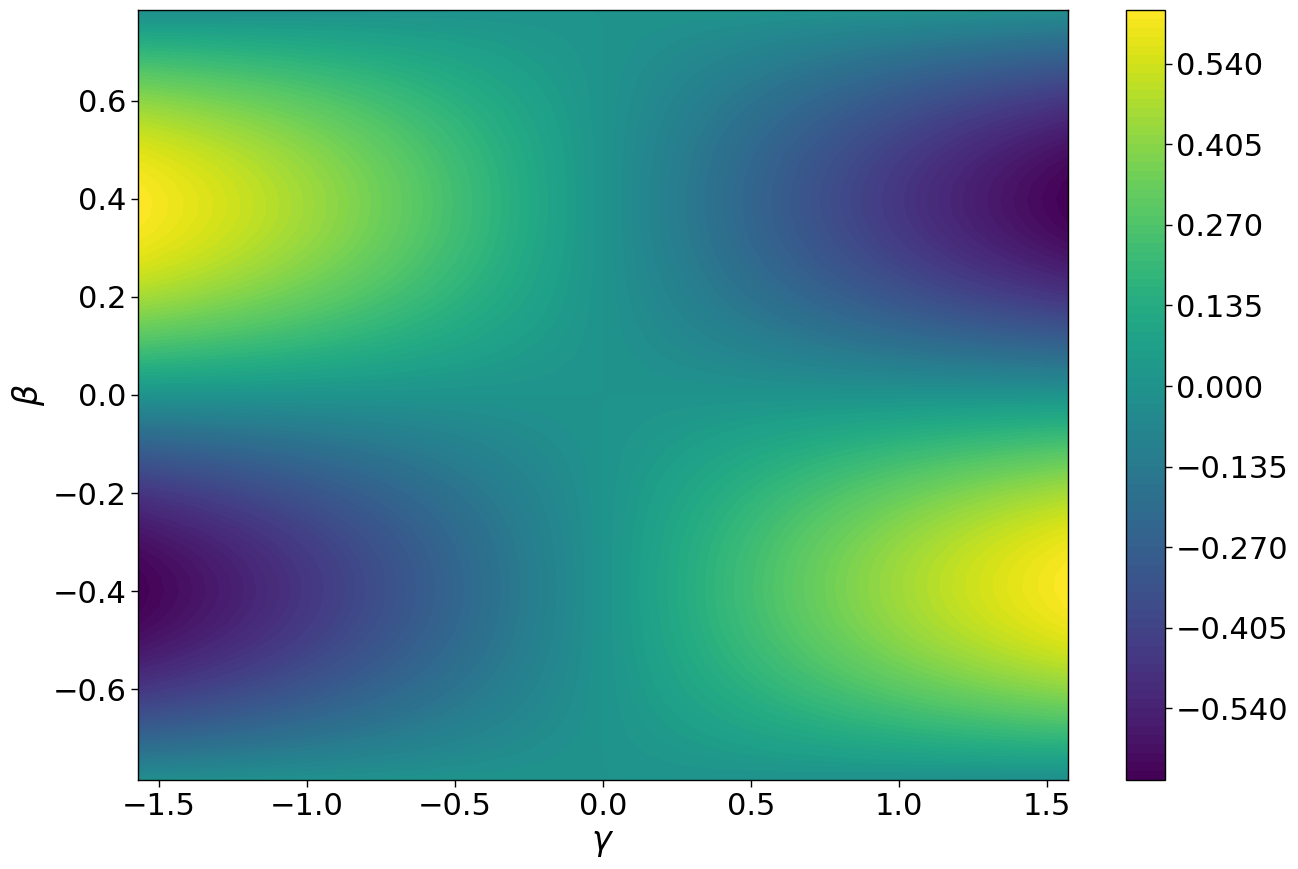

In [88]:
plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


In [121]:
optimizer = "newton"
init_beta = 0.5
init_gamma = -0.2

opt_results = run_qaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

# TODO which order are the angles saved in?
optimization_angles = np.array(opt_results.intermediate['angles log'])

optimization_energy = opt_results.intermediate['intermediate cost'][-1]

most_probable_energy = opt_results.most_probable_states['bitstring_energy']

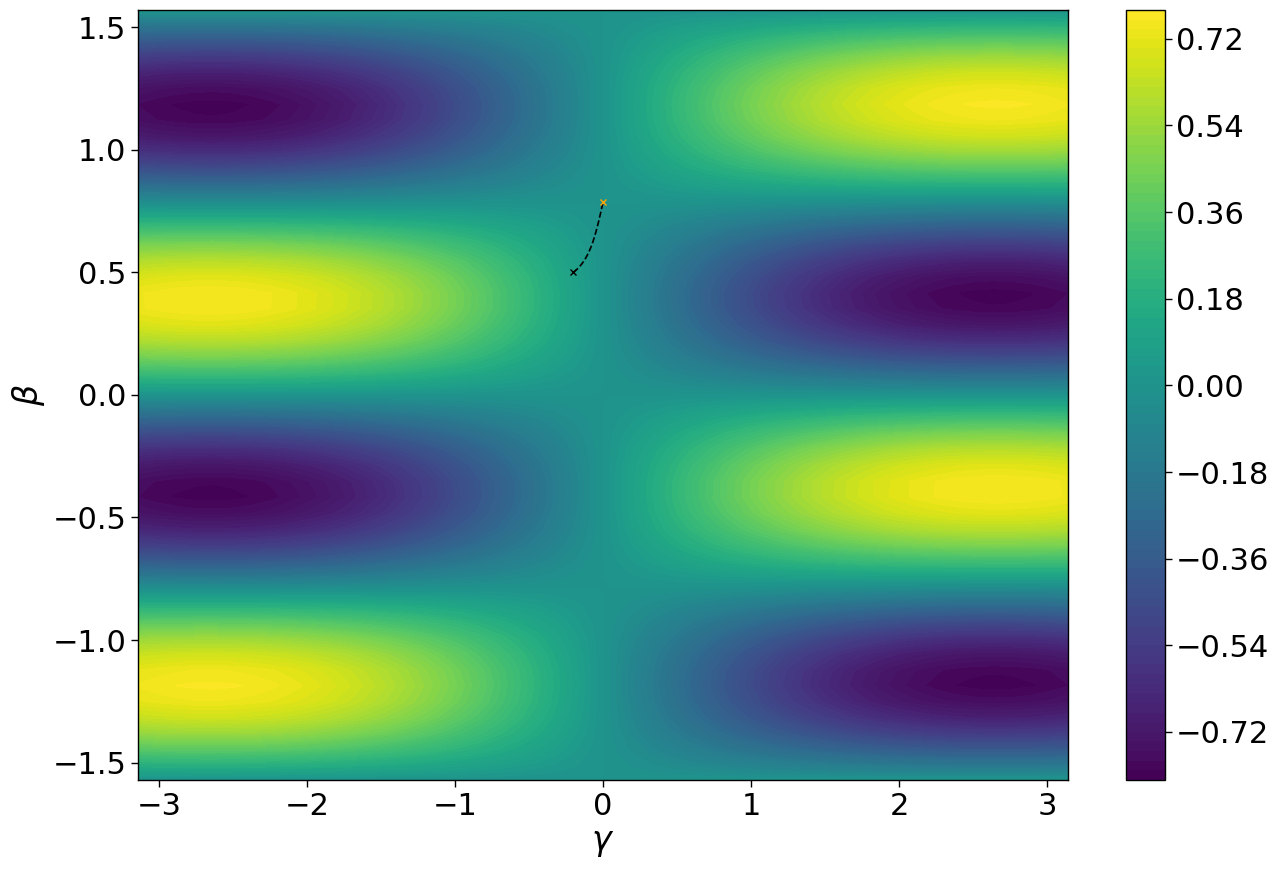

In [122]:
plot_landscape_with_opt_trajectory(cost_landscape_std, optimization_angles, betas, gammas, sigma, optimizer)
# Newton 

In [ ]:
optimizer = "rmsprop"
init_beta = 0.5
init_gamma = -0.2

opt_results = run_qaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

# TODO which order are the angles saved in?
optimization_angles = np.array(opt_results.intermediate['angles log'])

optimization_energy = opt_results.intermediate['intermediate cost'][-1]

most_probable_energy = opt_results.most_probable_states['bitstring_energy']

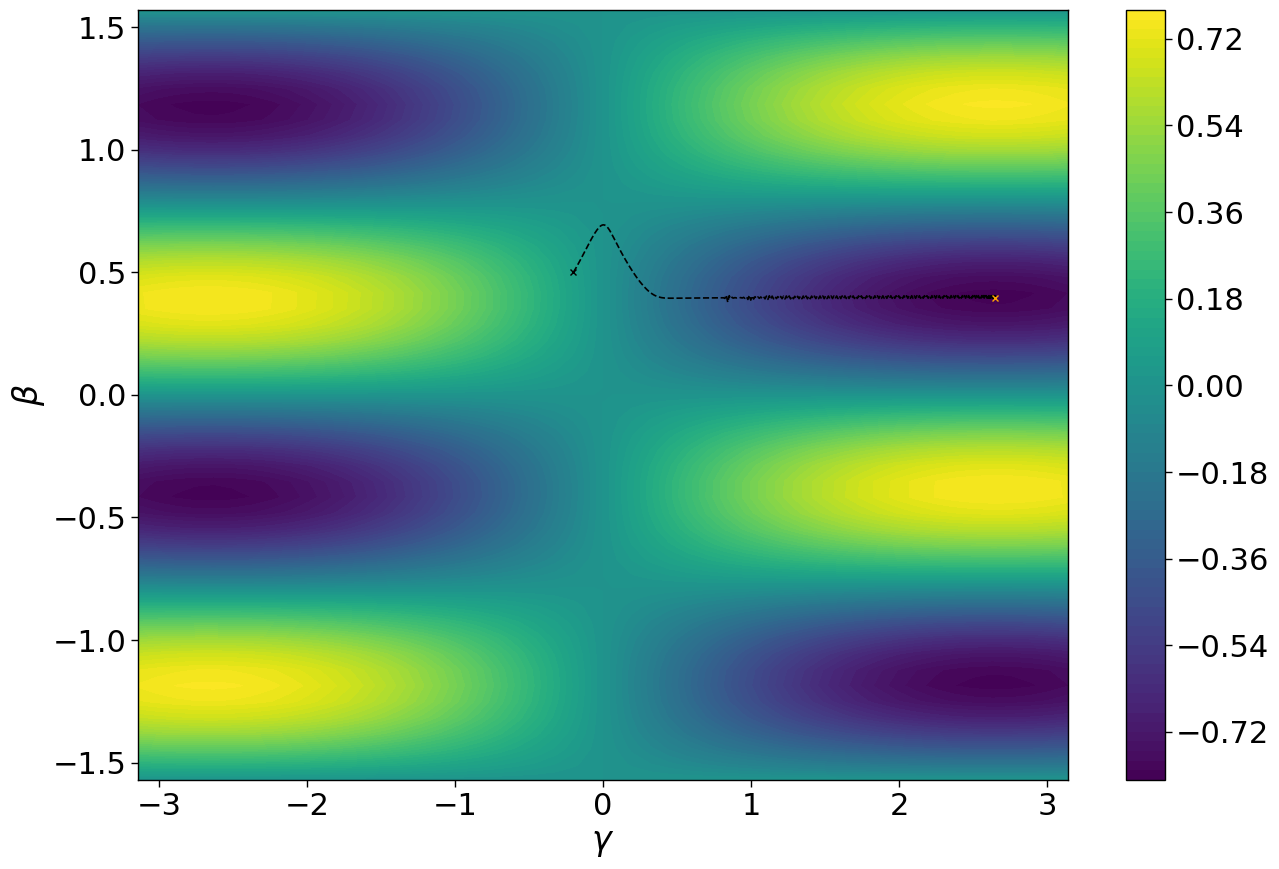

In [120]:
plot_landscape_with_opt_trajectory(cost_landscape_std, optimization_angles, betas, gammas, sigma, optimizer)
# RMS prop

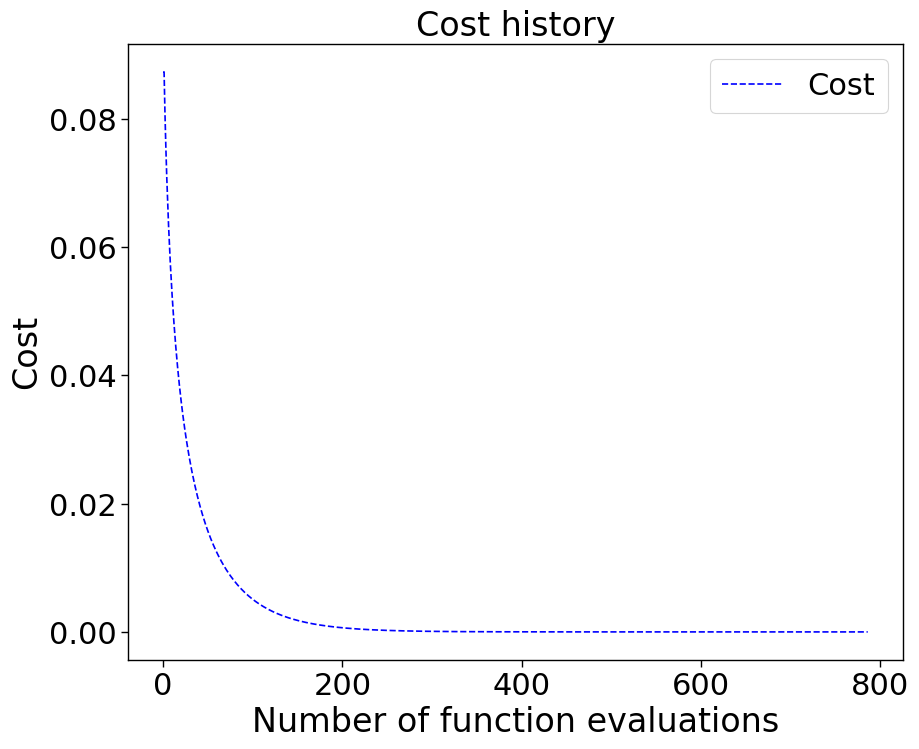

In [102]:
# print the cost history
opt_results.plot_cost()

In [117]:
opt_results.evals

{'number of evals': 3156, 'jac evals': 2804, 'qfim evals': 0}

In [88]:
# Solve the problem analytically
energy, configuration = ground_state_hamiltonian(cost_hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")


Ground State energy: -1.52520280502617, Solution: ['100111011100', '011000100011']


In [89]:
# Obtain approximation ratio
r = np.abs(optimization_energy) / np.abs(energy)
print("Approximation ratio = ", r)

most_probable_r = np.abs(most_probable_energy) / np.abs(energy)
print("Most probable string approximation ratio = ", most_probable_r)


Approximation ratio =  0.5321219106786415
Most probable string approximation ratio =  1.0


In [84]:
from openqaoa.optimizers import available_optimizers

In [85]:
available_optimizers()

{'scipy': ['nelder-mead',
  'powell',
  'cg',
  'bfgs',
  'newton-cg',
  'l-bfgs-b',
  'tnc',
  'cobyla',
  'slsqp',
  'trust-constr',
  'dogleg',
  'trust-ncg',
  'trust-exact',
  'trust-krylov'],
 'custom_scipy_gradient': ['vgd',
  'newton',
  'rmsprop',
  'natural_grad_descent',
  'spsa']}

### Compare different optimizers

In [34]:

'''
The classical optimization method. Choose from:
['imfil','bobyqa','snobfit']
['vgd', 'sgd', 'rmsprop'] 
['nelder-mead','powell','cg','bfgs','newton-cg','l-bfgs-b','cobyla'] 

'sgd' has been commented out
SPSA is an experimental feature.
'natural_grad_descent' converges in too many iterations
'''

optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

data = []  # list to contain optimization results to be converted into a data frame

intermediate_cost_all = {}  # dictionary to contain the cost progress during optimization for all optimizers

for optimizer in optimizer_list:
    print(sigma)
    print(optimizer)
    
    # initialize away from the minimum
    init_beta = 0.0
    init_gamma = -0.0

    opt_results = run_qaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)
    
    intermediate_cost = opt_results.intermediate['intermediate cost']
    intermediate_cost_all[optimizer] = intermediate_cost
    
    optimization_energy = opt_results.intermediate['intermediate cost'][-1]
    most_probable_energy = opt_results.most_probable_states['bitstring_energy']

    # Obtain approximation ratio
    r = np.abs(optimization_energy) / np.abs(energy)

    most_probable_r = np.abs(most_probable_energy) / np.abs(energy)

    data.append([sigma, optimizer, r, most_probable_r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'r', 'most_probable_r'])
    
df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)
df['most_probable_r'] = df['most_probable_r'].astype(float)

1.0
vgd
1.0
rmsprop
1.0
newton-cg
1.0
cobyla


/Users/kk/Workspace/OpenQAOA/venv/lib/python3.9/site-packages/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/Users/kk/Workspace/OpenQAOA/venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:687: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


1.0
nelder-mead


/Users/kk/Workspace/OpenQAOA/venv/lib/python3.9/site-packages/openqaoa/optimizers/training_vqa.py:470: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


1.0
powell


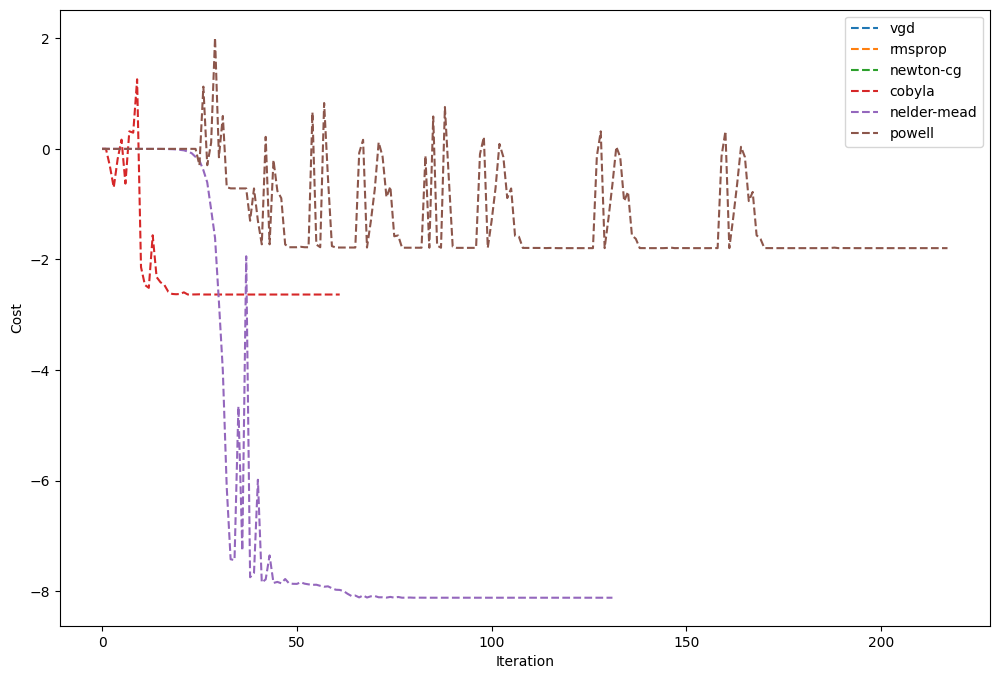

In [35]:
for optimizer in optimizer_list:
    plt.plot(np.arange(0, len(intermediate_cost_all[optimizer])), intermediate_cost_all[optimizer], label=optimizer, linestyle='--')

plt.legend()
#plt.xscale('log')
plt.savefig("optimizers_history_sigma={}_mu={}_beta={}_gamma={}.png".format(sigma, mu, init_beta, init_gamma))
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [24]:
df

,sigma,optimizer,r,most_probable_r
0,1.0,vgd,0.532122,1.0
1,1.0,rmsprop,0.532122,1.0
2,1.0,newton-cg,0.532122,1.0
3,1.0,cobyla,0.532122,1.0
4,1.0,nelder-mead,0.532122,1.0
5,1.0,powell,0.532122,1.0


In [25]:
df.to_csv("data.csv")

In [44]:
for e in np.arange(1, 5):
    print(type(e))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [60]:
np.arange(1, 10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Averaging over instances 

In [8]:
# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 0.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["rmsprop", 'nelder-mead']

#seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            # initialize away from the minimum
            init_beta = 0.5
            init_gamma = -0.2

            opt_results = run_qaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = opt_results.intermediate['intermediate cost'][-1]
            most_probable_energy = opt_results.most_probable_states['bitstring_energy']
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)

            most_probable_r = np.abs(most_probable_energy) / np.abs(energy)

            data.append([sigma, optimizer, seed, r, most_probable_r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r', 'most_probable_r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)
df['most_probable_r'] = df['most_probable_r'].astype(float)





Sigma = 0.1
Seed = 1
Optimizer = rmsprop
Optimizer = nelder-mead


/Users/kk/Workspace/OpenQAOA/venv/lib/python3.9/site-packages/openqaoa/optimizers/training_vqa.py:470: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 2
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 3
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 4
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 5
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 6
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 7
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 8
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 9
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 10
Optimizer = rmsprop
Optimizer = nelder-mead
Sigma = 1
Seed = 1
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 2
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 3
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 4
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 5
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 6
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 7
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 8
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 9
Optimizer = rmsprop
Optimizer = nelder-mead
Seed = 10
Optimizer = rmsprop
Optim

In [9]:
df

,sigma,optimizer,seed,r,most_probable_r
0,0.1,rmsprop,1,0.532095,1.000000
1,0.1,nelder-mead,1,0.532122,1.000000
2,0.1,rmsprop,2,0.525726,1.000000
3,0.1,nelder-mead,2,0.525755,1.000000
4,0.1,rmsprop,3,0.518572,1.000000
...,...,...,...,...,...
75,100.0,nelder-mead,8,0.092839,0.338318
76,100.0,rmsprop,9,0.011811,0.361356
77,100.0,nelder-mead,9,0.181399,0.403332
78,100.0,rmsprop,10,0.055993,0.003104


<AxesSubplot:xlabel='sigma', ylabel='most_probable_r'>

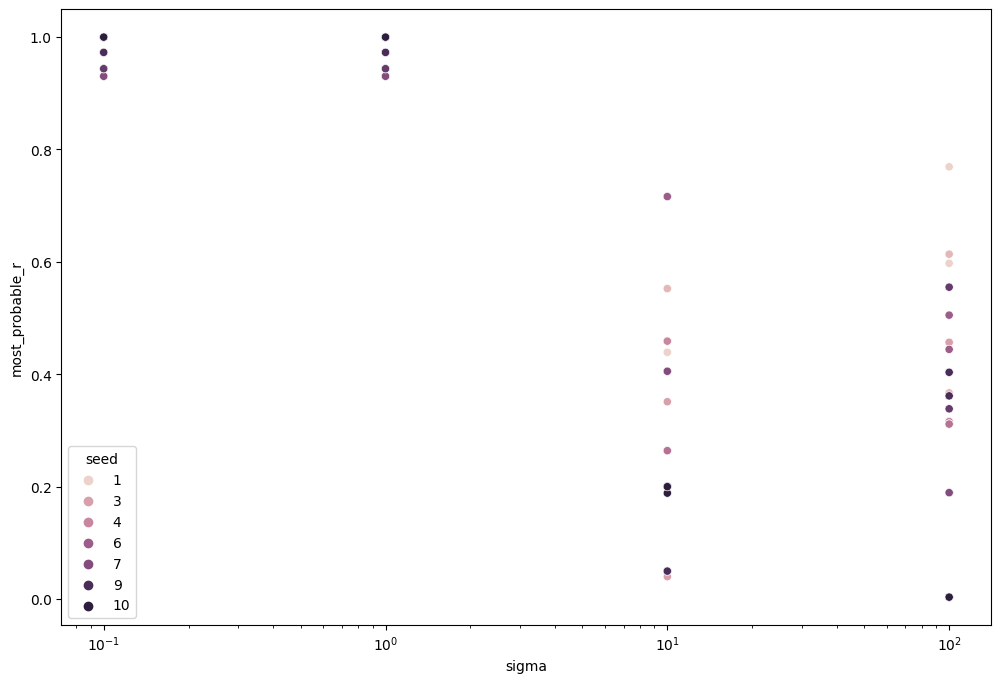

In [11]:
plt.xscale('log')
sns.scatterplot(data = df, x = 'sigma', y ='most_probable_r', hue="seed")
#plt.savefig("Most_probable_approximation_ratio.png")

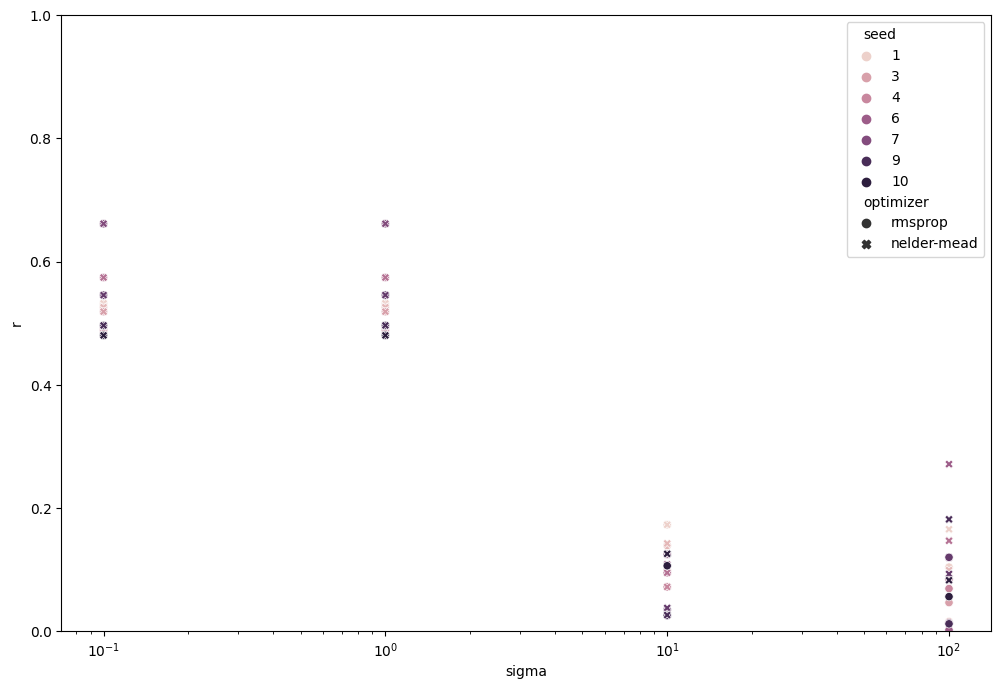

In [18]:
plt.xscale('log')
plt.ylim(0, 1)
sns.scatterplot(data = df, x = 'sigma', y ='r', hue="seed", style="optimizer")
plt.savefig("Approximation_ratio.png")

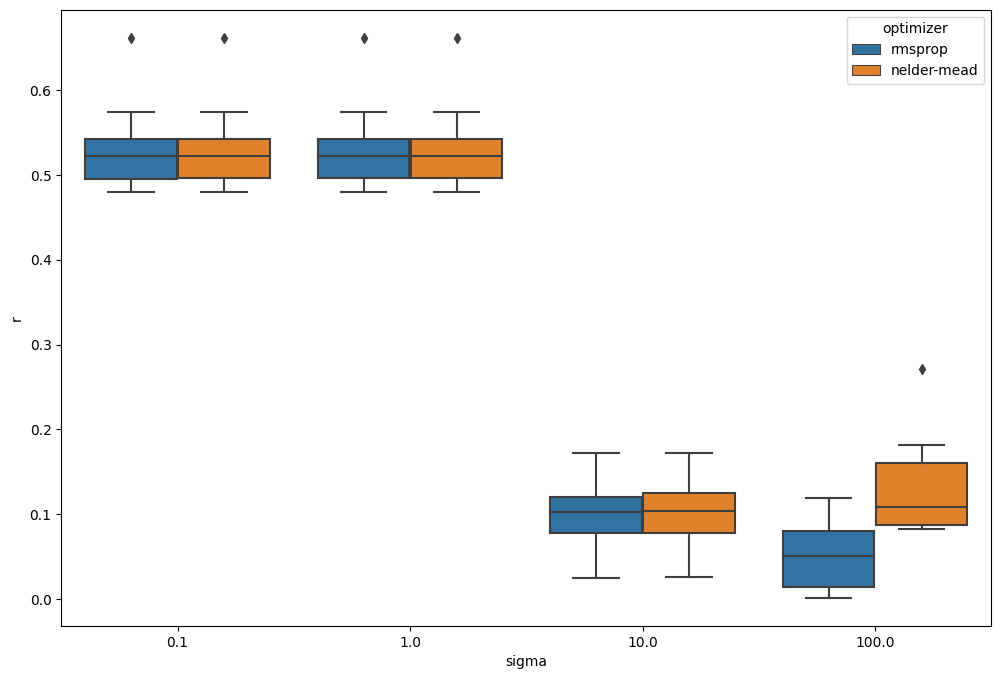

In [17]:
#plt.xscale('log')
#plt.ylim(0, 1)
sns.boxplot(data = df, x = 'sigma', y ='r', hue="optimizer")
plt.savefig("Approximation_ratio_averages_nelder-mead_rmsprop.png")